In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import yaml
import copy
import torch
import pickle
import logging
import traceback
import numpy as np
import pandas as pd
import tensorflow as tf
import multiprocessing as mp
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
from geckoml.models import DenseNeuralNetwork, GRUNet
from geckoml.metrics import *
from geckoml.data import *
#from geckoml.box import *

from scipy.stats import pearsonr
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

import tqdm

In [2]:
%matplotlib inline

In [3]:
def get_stability(preds, stability_thresh):
    """
    Determine if any value has crossed the positive or negative magnitude of threshold and lable unstable if true
    Args:
        preds (pd.DataFrame): Predictions
        stability_thresh: Threshold to determine if an exp has gone unstable (uses positive and negative values)
    Returns:
        stable_exps (list)
        unstable_exps (list)
    """
    preds = preds.copy()
    preds['Precursor [ug/m3]'] = 10**(preds['Precursor [ug/m3]'])
    
    unstable = preds.groupby('id')['Precursor [ug/m3]'].apply(
        lambda x: x[(x > stability_thresh) | (x < -stability_thresh)].any())
    stable_exps = unstable[unstable == False].index
    unstable_exps = unstable[unstable == True].index

    return stable_exps, unstable_exps

In [4]:
def EarthMoverDist2D(Y1, Y2): 
    # https://stackoverflow.com/questions/57562613/python-earth-mover-distance-of-2d-arrays
    d = cdist(Y1, Y2)
    assignment = linear_sum_assignment(d)
    return d[assignment].sum() / Y1.shape[0]


def metrics(truth, preds, stable_thresh = 1.0):
        
    for i, l in zip([1,2,3], ["prec", "gas", "aero"]):
        t = truth.iloc[:, i]
        p = preds.iloc[:, i]
        
        if i == 1:
            t = 10**t
            p = 10**p
        
        mae = mean_absolute_error(t,p)
        r2 = r2_corr(t, p)
        hd = hellinger_distance(t, p)
        pearson = pearsonr(t,p)[0]

        experiments = int(t.shape[0] / 1439)
        t = t.to_numpy().reshape((experiments, 1439))
        p = p.to_numpy().reshape((experiments, 1439))
        emd = EarthMoverDist2D(t, p)
        
        print(f"{l} -- ", f"MAE: {mae:.5f} R2: {r2:.3f} Pearson {pearson:.3f} Hellinger: {hd:.5f} EMD: {emd:.3f}") 

In [5]:
def plot(truth, preds, fontsize = 14, prec_lim = 0.085, gas_lim = 0.034, aero_lim = 0.0105):

    plt.figure(figsize=(12,8))

    for k, exp in enumerate(["Exp1709", "Exp1632", "Exp1769"]):
        colors = ["r", "g", "b"]

        #exp = "Exp1769"
        c1 = (preds["id"] == exp)
        c2 = (truth["id"] == exp)

        #plt.title(f"{exp}")

        plt.subplot(3, 3, k + 1)
        plt.plot(preds[c1]["Time [s]"] / 3600, 
                 10**preds[c1]["Precursor [ug/m3]"], 
                 c = colors[k], 
                 linewidth = 3)
        plt.plot(truth[c2]["Time [s]"] / 3600, 
                 10**truth[c2]["Precursor [ug/m3]"], 
                 ls = '--', 
                 c = 'k', 
                 linewidth = 3)
        if k == 0:
            plt.ylabel("Precursor", fontsize=fontsize)

        plt.legend(["Pred", "True"], fontsize=fontsize)
        plt.ylim([0, prec_lim])
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.title(exp, fontsize=fontsize)
        
    #     plt.tick_params(axis = "both", left='on', top='off', right='off', bottom='on', 
    #                     labelleft='off' if k > 0 else 'on', 
    #                     labeltop='off', 
    #                     labelright='off', 
    #                     labelbottom='off' if k != 2 else 'on',
    #                     direction = "in")

        plt.subplot(3, 3, k + 4)
        plt.plot(preds[c1]["Time [s]"] / 3600, preds[c1]["Gas [ug/m3]"], c = colors[k], linewidth = 3)
        plt.plot(truth[c2]["Time [s]"] / 3600, truth[c2]["Gas [ug/m3]"], ls = '--', c = 'k', linewidth = 3)
        if k == 0:
            plt.ylabel("Gas", fontsize=fontsize)
        #plt.legend(["Pred", "True"])
        #plt.xlim([0, 1440])
        plt.ylim([0, gas_lim])
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.subplot(3, 3, k + 7)
        plt.plot(preds[c1]["Time [s]"] / 3600, preds[c1]["Aerosol [ug_m3]"], c = colors[k], linewidth = 3)
        plt.plot(truth[c2]["Time [s]"] / 3600, truth[c2]["Aerosol [ug_m3]"], ls = '--', c = 'k', linewidth = 3)
        if k == 0:
            plt.ylabel("Aerosol", fontsize=fontsize)
        plt.xlabel("Time (hr)", fontsize=fontsize)
        #plt.legend(["Pred", "True"])
        plt.ylim([0, aero_lim])
        #plt.xlim([0, 1440])
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

    plt.tight_layout()
    plt.show()

In [21]:
def box_val(mod, exps, num_timesteps, in_array, env_array, y_scaler, output_cols, out_val, stable_thresh = 1.0):
    
    # use initial condition @ t = 0 and get the first prediction
    pred_array = np.empty((len(exps), 1439, 3))
    pred = mod.predict(in_array[:, 0, :])
    pred_array[:, 0, :] = pred

    # use the first prediction to get the next, and so on for num_timesteps
    for i in tqdm.tqdm(range(1, num_timesteps)):
        temperature = in_array[:, i, 3:4]
        static_env = env_array[:, -5:]
        new_input = np.block([pred, temperature, static_env])
        #pred = mod(new_input, training=False)
        pred = mod.predict(new_input)
        pred_array[:, i, :] = pred

    # loop over the batch to fill up results dict
    results_dict = {}
    for k, exp in enumerate(exps):
        results_dict[exp] = pd.DataFrame(y_scaler.inverse_transform(pred_array[k]), columns=output_cols[1:-1])
        results_dict[exp]['id'] = exp
        results_dict[exp]['Time [s]'] = out_val['Time [s]'].unique()
        results_dict[exp] = results_dict[exp].reindex(output_cols, axis=1)

    preds = pd.concat(results_dict.values())
    truth = out_val.loc[out_val['id'].isin(exps)]
    truth = truth.sort_values(['id', 'Time [s]']).reset_index(drop=True)
    preds = preds.sort_values(['id', 'Time [s]']).reset_index(drop=True)
    
    stable_exps, failed_exps = get_stability(preds, stable_thresh)
        
    c1 = ~truth["id"].isin(failed_exps)
    c2 = ~preds["id"].isin(failed_exps)
    box_mae = mean_absolute_error(preds[c2].iloc[:, 2:-1], truth[c1].iloc[:, 2:-1])
    
    return box_mae, truth, preds, failed_exps

In [7]:
def box_val_rnn(mod, exps, num_timesteps, in_array, env_array, y_scaler, output_cols, out_val, stable_thresh = 1.0):
    with torch.no_grad():
        # use initial condition @ t = 0 and get the first prediction
        pred_array = np.empty((len(exps), 1439, 3))
        h0 = mod.init_hidden(torch.from_numpy(in_array[:, 0, :]).float())
        pred, h0 = mod.predict(in_array[:, 0, :], h0)
        pred_array[:, 0, :] = pred

        # use the first prediction to get the next, and so on for num_timesteps
        for i in range(1, num_timesteps): 
            temperature = in_array[:, i, 3:4]
            static_env = env_array[:, -5:]
            new_input = np.block([pred, temperature, static_env])
            pred, h0 = mod.predict(new_input, h0)
            pred_array[:, i, :] = pred

    # loop over the batch to fill up results dict
    results_dict = {}
    for k, exp in enumerate(exps):
        results_dict[exp] = pd.DataFrame(y_scaler.inverse_transform(pred_array[k]), columns=output_cols[1:-1])
        results_dict[exp]['id'] = exp
        results_dict[exp]['Time [s]'] = out_val['Time [s]'].unique()
        results_dict[exp] = results_dict[exp].reindex(output_cols, axis=1)

    preds = pd.concat(results_dict.values())
    truth = out_val.loc[out_val['id'].isin(exps)]
    truth = truth.sort_values(['id', 'Time [s]']).reset_index(drop=True)
    preds = preds.sort_values(['id', 'Time [s]']).reset_index(drop=True)
    
    stable_exps, failed_exps = get_stability(preds, stable_thresh)        
    c1 = ~truth["id"].isin(failed_exps)
    c2 = ~preds["id"].isin(failed_exps)
    
    box_mae = mean_absolute_error(preds[c2].iloc[:, 2:-1], truth[c1].iloc[:, 2:-1])
    
    return box_mae, truth, preds, failed_exps

### Load a species configuration (having the latest torch settings for the rnn model)

In [8]:
with open("../echo/toluene/6/model.yml") as config_file:
    conf = yaml.load(config_file, Loader=yaml.FullLoader)

### Specify the locations of the model weights

In [9]:
# toluene
tolu_keras_mlp = "/glade/work/keelyl/geckonew/gecko-ml/toluene_agg_runs_unvaried/4_27_models/toluene_dnn_1_6/"
tolu_torch_rnn = "/glade/work/schreck/repos/GECKO_OPT/gecko-ml/echo/toluene/6/best.pt"

# apin
apin_keras_mlp = "/glade/work/keelyl/geckonew/gecko-ml/apin_agg_runs/05_14_models/apin_O3_dnn_1_2/"
apin_torch_rnn = "/glade/work/schreck/repos/GECKO_OPT/gecko-ml/echo/apin/7/best.pt"

# dodecane
dode_keras_mlp = "/glade/work/keelyl/geckonew/gecko-ml/dodecane_agg_runs/05_06_models/dodecane_dnn_1_6/"
dode_torch_rnn = "/glade/work/schreck/repos/GECKO_OPT/gecko-ml/echo/dodecane/3/best.pt"

### Load and prepare the training and validation data

In [10]:
# Load conf args
species = conf['species']
output_path = conf['output_path']
exps = conf['box_val_exps']
input_cols = conf['input_vars']
output_cols = conf['output_vars']
columns = ['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']

aggregate_bins = conf['aggregate_bins']
input_vars = conf['input_vars']
output_vars = conf['output_vars']

# Load the data
try:
    in_train = pd.read_parquet(join(output_path, 'validation_data', f'{species}_in_train.parquet'))
    out_train = pd.read_parquet(join(output_path, 'validation_data', f'{species}_out_train.parquet'))
    in_val = pd.read_parquet(join(output_path, 'validation_data', f'{species}_in_val.parquet'))
    out_val = pd.read_parquet(join(output_path, 'validation_data', f'{species}_out_val.parquet'))
except:
    in_train = pd.read_csv(f'/glade/scratch/cbecker/gecko_data/{species}_train_in_agg.csv')
    out_train = pd.read_csv(f'/glade/scratch/cbecker/gecko_data/{species}_train_out_agg.csv')
    in_val = pd.read_csv(f'/glade/scratch/cbecker/gecko_data/{species}_val_in_agg.csv')
    out_val = pd.read_csv(f'/glade/scratch/cbecker/gecko_data/{species}_val_out_agg.csv')

num_timesteps = in_train['Time [s]'].nunique()

try:
    x_scaler = joblib.load(join(output_path, 'scalers', f'{species}_x.scaler'))
    y_scaler = joblib.load(join(output_path, 'scalers', f'{species}_y.scaler'))
except:
    # Rescale training and validation / testing data
    scalers = {"MinMaxScaler": MinMaxScaler, "StandardScaler": StandardScaler}
    scaler_type = conf['scaler_type']
    if scaler_type == "MinMaxScaler":
        x_scaler = scalers[scaler_type]((conf['min_scale_range'], conf['max_scale_range']))
    else:
        x_scaler = scalers[scaler_type]()
        x_scaler = x_scaler.fit(in_train.drop(['Time [s]', 'id'], axis=1))

#scaled_in_train = x_scaler.transform(in_train.drop(['Time [s]', 'id'], axis=1))

scaled_in_train = x_scaler.fit_transform(in_train.drop(['Time [s]', 'id'], axis=1))
scaled_in_val = x_scaler.transform(in_val.drop(['Time [s]', 'id'], axis=1))

y_scaler = get_output_scaler(x_scaler, output_vars, scaler_type, data_range=(
    conf['min_scale_range'], conf['max_scale_range']))

scaled_out_train = y_scaler.transform(out_train.drop(['Time [s]', 'id'], axis=1))
scaled_out_val = y_scaler.transform(out_val.drop(['Time [s]', 'id'], axis=1))

y = partition_y_output(scaled_out_train, 1, aggregate_bins)
y_val = partition_y_output(scaled_out_val, 1, aggregate_bins)

In [11]:
if species == "toluene":
    keras_mlp = tolu_keras_mlp
    torch_rnn = tolu_torch_rnn
    prec_lim = 0.05
    gas_lim = 0.0275
    aero_lim = 0.008
elif species == "dodecane":
    keras_mlp = dode_keras_mlp
    torch_rnn = dode_torch_rnn
    prec_lim = 0.075
    gas_lim = 0.1
    aero_lim = 0.08
else:
    keras_mlp = apin_keras_mlp
    torch_rnn = apin_torch_rnn
    prec_lim = 0.075
    gas_lim = 0.1
    aero_lim = 0.07
    
fontsize = 14

In [17]:
# Batch the training experiments 
#logging.info("Batching the training data by experiment, this may take a few minutes")
def work(exp):
    in_data = x_scaler.transform(in_train[in_train['id'] == exp].iloc[:, 1:-1])
    env_conds = in_data[0, -6:]
    return (np.expand_dims(in_data, axis=0), np.expand_dims(env_conds, axis=0))
train_exps = list(in_train['id'].unique())
with mp.Pool(processes=8) as p:
    in_array, env_array = zip(*[result for result in tqdm.tqdm(p.imap(work, train_exps), total=len(train_exps))])
#in_array, env_array = zip(*[work(x) for x in train_exps])
in_array = np.concatenate(in_array) # (num_experiments, num_timesteps, outputs)
env_array = np.concatenate(env_array)

100%|██████████| 1600/1600 [00:23<00:00, 68.20it/s]


TypeError: 'module' object is not callable

In [18]:
#logging.info("Batching the validation data by experiment")
def work(exp):
    in_data = x_scaler.transform(in_val[in_val['id'] == exp].iloc[:, 1:-1])
    env_conds = in_data[0, -6:]
    return (np.expand_dims(in_data, axis=0), np.expand_dims(env_conds, axis=0))
val_exps = list(in_val['id'].unique())
val_in_array, val_env_array = zip(*[work(x) for x in tqdm.tqdm(val_exps)])
val_in_array = np.concatenate(val_in_array) # (num_experiments, num_timesteps, outputs)
val_env_array = np.concatenate(val_env_array)

100%|██████████| 200/200 [00:03<00:00, 64.51it/s]


### Linear regression model

In [13]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(scaled_in_train, y[0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
lin_mae, truth, preds, failed_exps = box_val(
    lin_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    y_scaler, 
    output_cols, 
    out_val
)

In [36]:
lin_mae

0.0027381539144234945

In [37]:
failed_exps

Index([], dtype='object', name='id')

In [38]:
metrics(truth, preds)

prec --  MAE: 0.00036 R2: 0.975 Pearson 0.988 Hellinger: 0.00014 EMD: 0.011
gas --  MAE: 0.00354 R2: 0.428 Pearson 0.654 Hellinger: 0.03190 EMD: 0.123
aero --  MAE: 0.00193 R2: 0.531 Pearson 0.728 Hellinger: 0.20457 EMD: 0.073


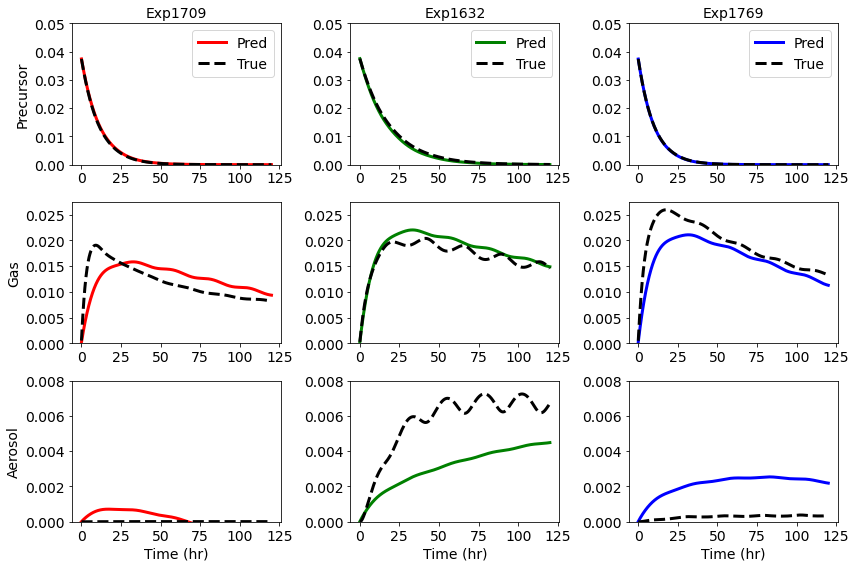

In [39]:
plot(truth, preds, fontsize, prec_lim, gas_lim, aero_lim)

### Random forest model

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
n = 2
n_samples = scaled_in_train.shape[0]
rf_model = RandomForestRegressor(n_estimators=n)
rf_model.fit(scaled_in_train[:n_samples], y[0][:n_samples])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [41]:
rf_mae, truth, preds, failed_exps = box_val(
    rf_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    y_scaler, 
    output_cols, 
    out_val
)

In [42]:
rf_mae

0.00508701672134834

In [43]:
failed_exps

Index([], dtype='object', name='id')

In [44]:
c1 = ~truth["id"].isin(failed_exps)
c2 = ~preds["id"].isin(failed_exps)

metrics(truth[c1], preds[c2])

prec --  MAE: 0.01445 R2: 0.361 Pearson 0.601 Hellinger: 0.50950 EMD: 0.577
gas --  MAE: 0.00805 R2: 0.007 Pearson 0.086 Hellinger: 0.23753 EMD: 0.309
aero --  MAE: 0.00213 R2: 0.165 Pearson 0.407 Hellinger: 0.11659 EMD: 0.077


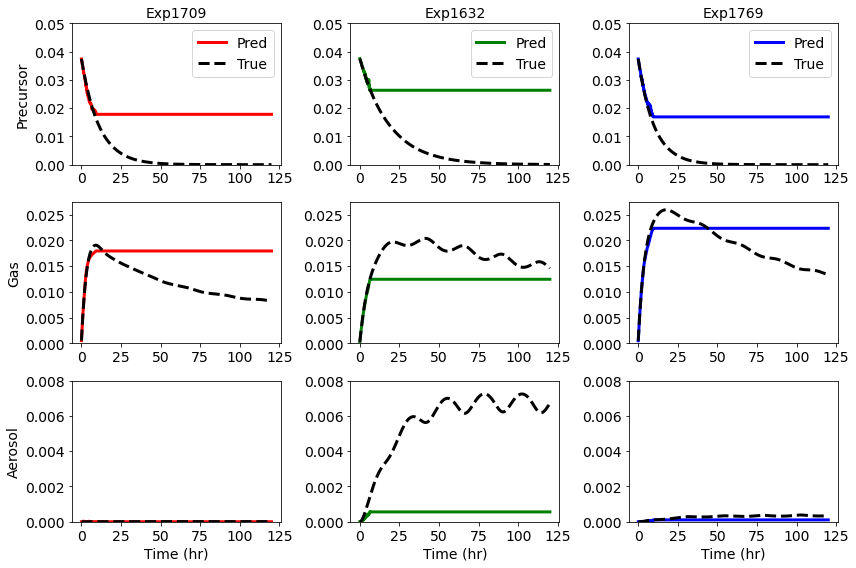

In [46]:
plot(truth, preds, fontsize, prec_lim, gas_lim, aero_lim)

### SVM 

In [19]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm

In [ ]:
svm_model = MultiOutputRegressor(svm.SVR())
svm_model.fit(scaled_in_train, y[0])

In [ ]:
svm_mae, truth, preds, failed_exps = box_val(
    svm_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    y_scaler, 
    output_cols, 
    out_val
)

In [ ]:
svm_mae

In [ ]:
failed_exps

In [ ]:
c1 = ~truth["id"].isin(failed_exps)
c2 = ~preds["id"].isin(failed_exps)

metrics(truth[c1], preds[c2])
plot(truth, preds, fontsize, prec_lim, gas_lim, aero_lim)

### KNN

In [14]:
from sklearn import neighbors

In [15]:
n_neighbors = 20
knn_model = MultiOutputRegressor(neighbors.KNeighborsRegressor(n_neighbors, weights='uniform'))
knn_model.fit(scaled_in_train, y[0])

MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=20,
                                                   p=2, weights='uniform'),
                     n_jobs=None)

In [23]:
knn_mae, truth, preds, failed_exps = box_val(
    knn_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    y_scaler, 
    output_cols, 
    out_val
)

100%|██████████| 1438/1438 [02:01<00:00, 11.81it/s]


In [24]:
knn_mae

0.003930791412043796

In [25]:
failed_exps

Index([], dtype='object', name='id')

prec --  MAE: 0.00804 R2: 0.265 Pearson 0.515 Hellinger: 0.13567 EMD: 0.330
gas --  MAE: 0.00650 R2: 0.130 Pearson 0.360 Hellinger: 0.13668 EMD: 0.246
aero --  MAE: 0.00136 R2: 0.584 Pearson 0.764 Hellinger: 0.01888 EMD: 0.026


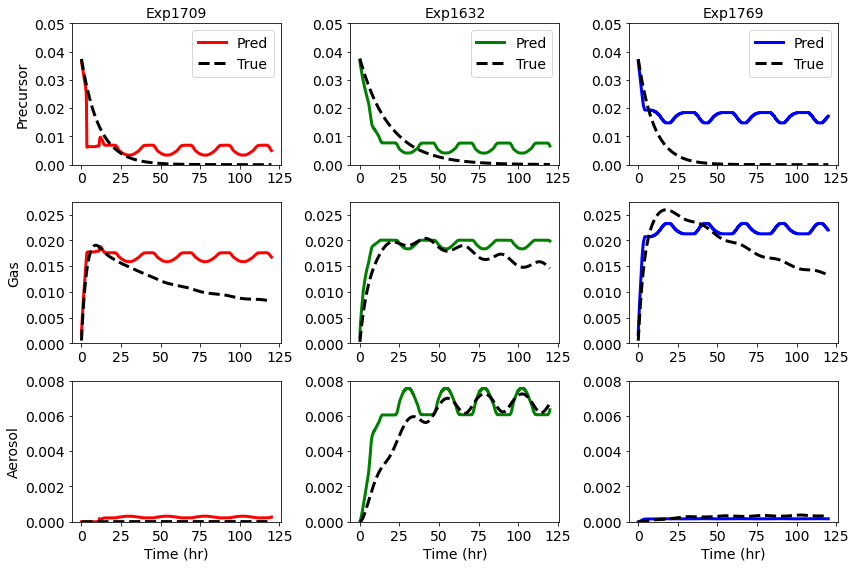

In [26]:
c1 = ~truth["id"].isin(failed_exps)
c2 = ~preds["id"].isin(failed_exps)

metrics(truth[c1], preds[c2])
plot(truth, preds, fontsize, prec_lim, gas_lim, aero_lim)

### Keras DNN

In [13]:
from tensorflow.keras.models import load_model

In [14]:
nn_model = tf.python.keras.models.load_model(
    keras_mlp,
    compile = False
)

In [15]:
nn_model.compile(metrics = ["mae"], loss = ["mae"])

In [16]:
nn_mae, truth, preds, failed_exps = box_val(
    nn_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    y_scaler, 
    output_cols, 
    out_val
)

In [17]:
nn_mae

0.0007905721637791658

In [18]:
failed_exps

Index([], dtype='object', name='id')

In [19]:
c1 = ~truth["id"].isin(failed_exps)
c2 = ~preds["id"].isin(failed_exps)

metrics(truth[c1], preds[c2])

prec --  MAE: 0.00041 R2: 0.982 Pearson 0.991 Hellinger: 0.00021 EMD: 0.014
gas --  MAE: 0.00093 R2: 0.944 Pearson 0.971 Hellinger: 0.00451 EMD: 0.033
aero --  MAE: 0.00065 R2: 0.909 Pearson 0.953 Hellinger: 0.01103 EMD: 0.017


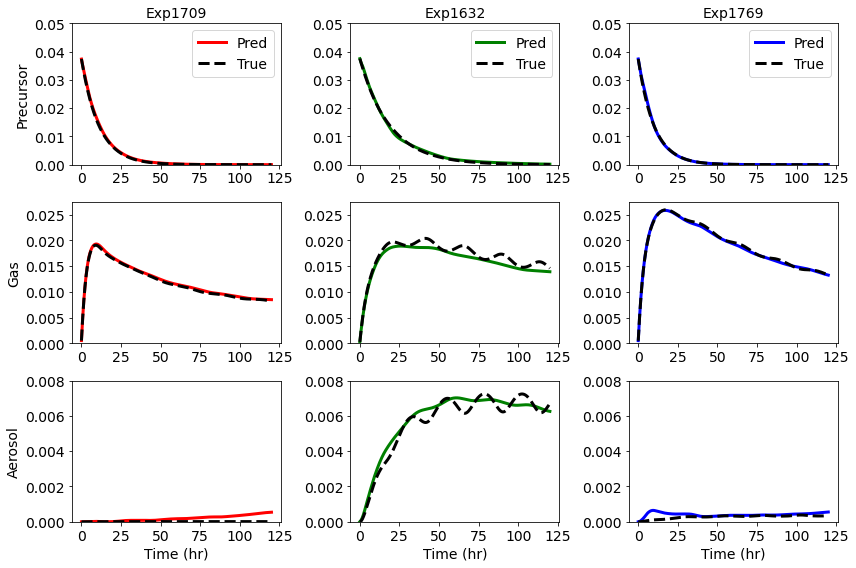

In [21]:
plot(truth, preds, fontsize, prec_lim, gas_lim, aero_lim)

### Torch GRU

In [13]:
# Get the GPU
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

#if is_cuda:
#    torch.backends.cudnn = False

In [15]:
input_size = val_in_array.shape[-1]
output_size = input_size - val_env_array.shape[-1]

rnn_conf = conf["model_configurations"]["single_ts_models"]["gru"]
n_layers = rnn_conf["n_layers"]
hidden_dim = rnn_conf["hidden_size"]
rnn_dropout = rnn_conf["rnn_dropout"]

model = GRUNet(hidden_dim, n_layers, rnn_dropout)
model.build(input_size, output_size, torch_rnn)
model = model.to(device)

The model contains 32111235 total parameters, 32111235 are trainable
Loading model weights from /glade/work/schreck/repos/GECKO_OPT/gecko-ml/echo/toluene/6/best.pt


In [16]:
rnn_mae, truth, preds, failed_exps = box_val_rnn(
    model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    y_scaler,
    output_cols, 
    out_val
)

In [17]:
rnn_mae

0.00025522564493081837

In [18]:
failed_exps

Index([], dtype='object', name='id')

prec --  MAE: 0.00016 R2: 0.995 Pearson 0.998 Hellinger: 0.00125 EMD: 0.015
gas --  MAE: 0.00030 R2: 0.993 Pearson 0.997 Hellinger: 0.00062 EMD: 0.014
aero --  MAE: 0.00021 R2: 0.991 Pearson 0.996 Hellinger: 0.02251 EMD: 0.008


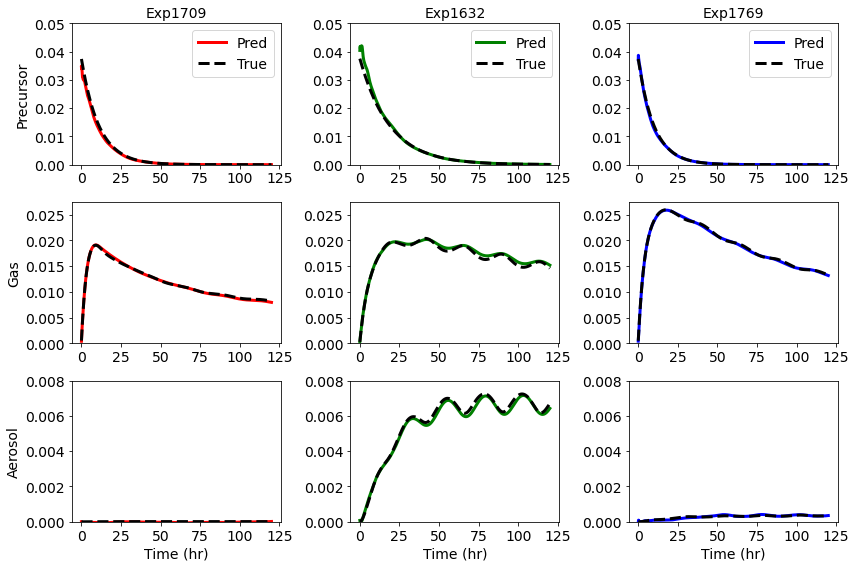

In [19]:
c1 = ~truth["id"].isin(failed_exps)
c2 = ~preds["id"].isin(failed_exps)

metrics(truth[c1], preds[c2])
plot(truth, preds, fontsize, prec_lim, gas_lim, aero_lim)

In [ ]:
# dodecane prec_lim = 0.075, gas_lim = 0.1, aero_lim = 0.08
# apin prec_lim = 0.075, gas_lim = 0.1, aero_lim = 0.07
# toluene prec_lim = 0.05, gas_lim = 0.0275, aero_lim = 0.008